In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import umap

In [2]:
# Finetune dataset, supervise learning (8:2, train:valid), (data, labels)
class Pathogenic_finetune(Dataset):
    def __init__(self, spectra_X, spectra_y, index_list=None, transform=None, ):
        self.X = spectra_X
        self.y = spectra_y
        self.transform = transform
        if index_list is None:
            self.index_list = np.arange(len(self.X))
        else:
            self.index_list = index_list

    def __getitem__(self, index):
        index = self.index_list[index]
        spectra, target = self.X[index], self.y[index].astype(int)
        if self.transform:
            spectra = self.transform(spectra)
        return spectra, target
    
    def __len__(self):
        return len(self.index_list)
    

# convert to Tensor with 1 channel
class ToFloatTensor(object):
    def __call__(self, x):
        return torch.from_numpy(x).view(1, -1).float()

In [3]:
def cluster_acc(Y_pred, Y):
    from scipy.optimize import linear_sum_assignment as linear_assignment
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    ind1, ind2 = linear_assignment(w.max() - w)
    return w[ind1, ind2].sum()*1.0/Y_pred.size, w

In [4]:
X = np.load('/home/RenPengju/codes/Raman_spectra/Dataset/bacteria_ID/X_reference.npy')
y = np.load('/home/RenPengju/codes/Raman_spectra/Dataset/bacteria_ID/y_reference.npy')
trainset = Pathogenic_finetune(X, y, transform=ToFloatTensor())

/home/RenPengju/.conda/envs/python310_pytorch/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


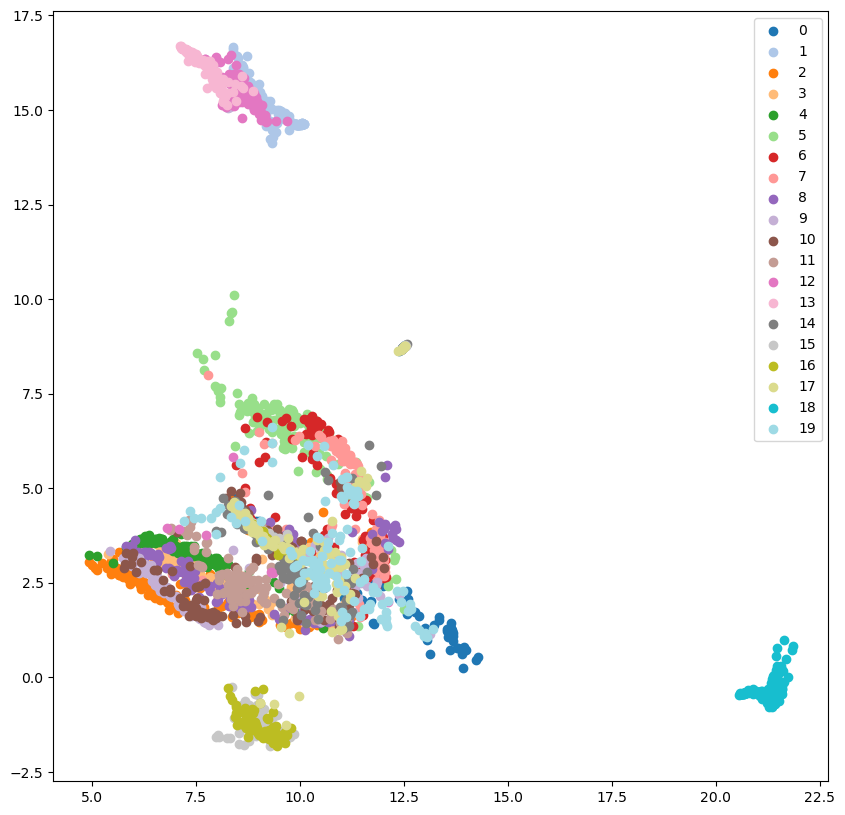

In [5]:
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
umap_result = umap_model.fit_transform(X)


fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('tab20')
for t in range(20):
    points = umap_result[t*2000: t*2000+128][y[t*2000: t*2000+128].astype(int) == t]
    ax.scatter(points[:, 0], points[:, 1], color=cmap(t), label=str(t))
ax.legend()


In [6]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=30, random_state=0)
kmeans_results = cluster.fit_predict(umap_result)
print('Acc = {:.4f}'.format(cluster_acc(kmeans_results, y.astype(int))[0] * 100))

/home/RenPengju/.conda/envs/python310_pytorch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc = 37.0533
